# Predict pseudobulks

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-08 18:23:56.116959: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 18:23:56.117390: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 18:23:56.119806: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 18:23:56.125700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736385836.135087 2539637 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736385836.13

W0000 00:00:1736385837.843382 2539637 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE154600_pseudobulks/"
consensus_ov_gene_path = f"{os.getcwd()}/../../data/consensusOV_genes.csv"


exp_id = "all-cellType"

if exp_id == "all-cellType":
    res_id = "cellType" # cellType subtype celltype_granular
elif exp_id == "all-granular":
    res_id = "celltype_granular"
elif exp_id == "all-subtype":
    res_id = "subtype"


curr_treatment = "drug"

in_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"

subtype_file = f"{sc_aug_data_path}/{exp_id}_subtypes.tsv"


In [3]:
adata = sc.read_h5ad(in_ad_file)

subtype_df = pd.read_csv(subtype_file, sep="\t")

if res_id == "subtype":
    adata.obs = adata.obs.rename({'IMR':'scIMR', 'DIF':'scDIF', 'PRO':'scPRO', 'MES':'scMES'}, axis=1)
    cell_types = ["scIMR", "scDIF", "scPRO", "scMES"]
elif res_id == "cellType":
    cell_types = ["CD8+ T-cells", "Macrophages", "Monocytes", 
                  "NK cells", "CD4+ T-cells", "B-cells", "Endothelial cells", "Adipocytes", "Mesangial cells",
                  "Fibroblasts", "Epithelial cells"]
else: # granular
    cell_types = ["immune", "stromal", "tumor"]



In [4]:
# append to obs they should be in exactly the same order
subtype_df.index = adata.obs.index
adata.obs = pd.concat([adata.obs, subtype_df], axis=1)

In [5]:

Y_full = adata.obs[cell_types]
Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
adata.obs["Y_max"] = Y_max

In [6]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,Macrophages,Epithelial cells,Monocytes,Adipocytes,CD8+ T-cells,...,CD4+ T-cells,Fibroblasts,B-cells,NK cells,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max
0,Samp_T59,CTRL,Train,random,sc_ref,0.030000,0.055000,0.205000,0.035000,0.210000,...,0.225000,0.060000,0.035000,0.025000,0.504,0.220,0.088,0.188,IMR,CD4+ T-cells
1,Samp_T59,CTRL,Train,random,sc_ref,0.275000,0.060000,0.005000,0.055000,0.010000,...,0.010000,0.030000,0.430000,0.010000,0.442,0.262,0.114,0.182,IMR,B-cells
2,Samp_T59,CTRL,Train,random,sc_ref,0.005000,0.070000,0.560000,0.005000,0.005000,...,0.005000,0.320000,0.005000,0.005000,0.290,0.206,0.140,0.364,MES,Monocytes
3,Samp_T59,CTRL,Train,random,sc_ref,0.020000,0.005000,0.025000,0.015000,0.515000,...,0.005000,0.010000,0.100000,0.010000,0.390,0.312,0.168,0.130,IMR,CD8+ T-cells
4,Samp_T59,CTRL,Train,random,sc_ref,0.015000,0.045000,0.115000,0.020000,0.255000,...,0.005000,0.015000,0.005000,0.365000,0.416,0.374,0.082,0.128,IMR,NK cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,Samp_T90,CTRL,Train,cell_type_specific,sc_ref,0.026668,0.010228,0.008148,0.003406,0.010293,...,0.041946,0.008384,0.002011,0.871835,0.922,0.066,0.004,0.008,IMR,NK cells
10496,Samp_T90,CTRL,Train,cell_type_specific,sc_ref,0.003836,0.101083,0.046046,0.099706,0.022706,...,0.004908,0.006378,0.005489,0.568911,0.376,0.310,0.088,0.226,IMR,NK cells
10497,Samp_T90,CTRL,Train,cell_type_specific,sc_ref,0.014555,0.049026,0.002625,0.005415,0.065198,...,0.007938,0.002805,0.035035,0.790416,0.636,0.258,0.042,0.064,IMR,NK cells
10498,Samp_T90,CTRL,Train,cell_type_specific,sc_ref,0.043397,0.008603,0.010396,0.006961,0.007803,...,0.006296,0.030603,0.007744,0.834686,0.632,0.062,0.028,0.278,IMR,NK cells


# Plot

In [7]:
sc.tl.pca(adata, n_comps=50)


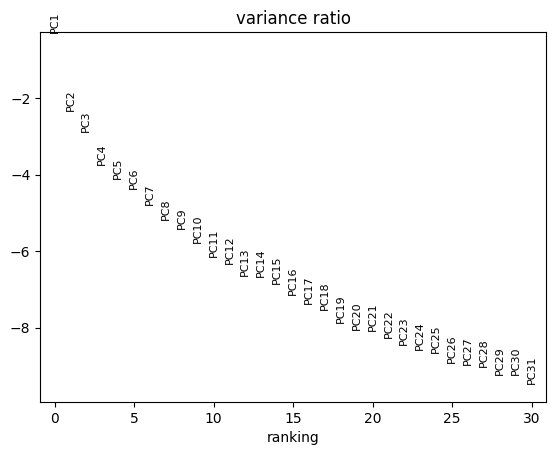

In [8]:
sc.pl.pca_variance_ratio(adata, log=True)


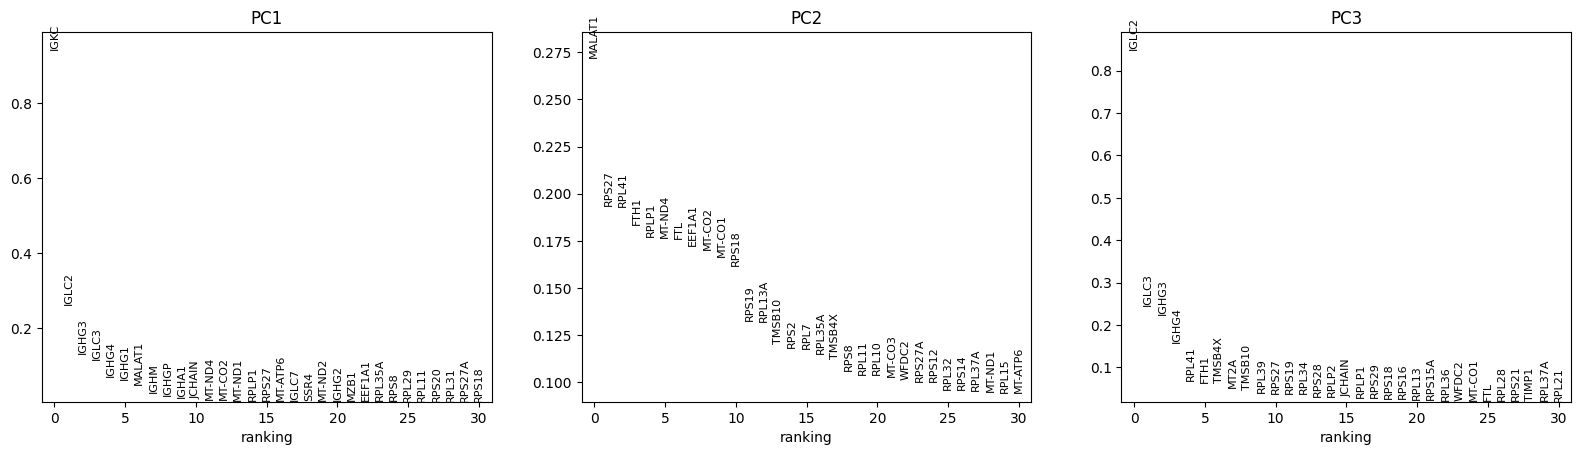

In [9]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [10]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


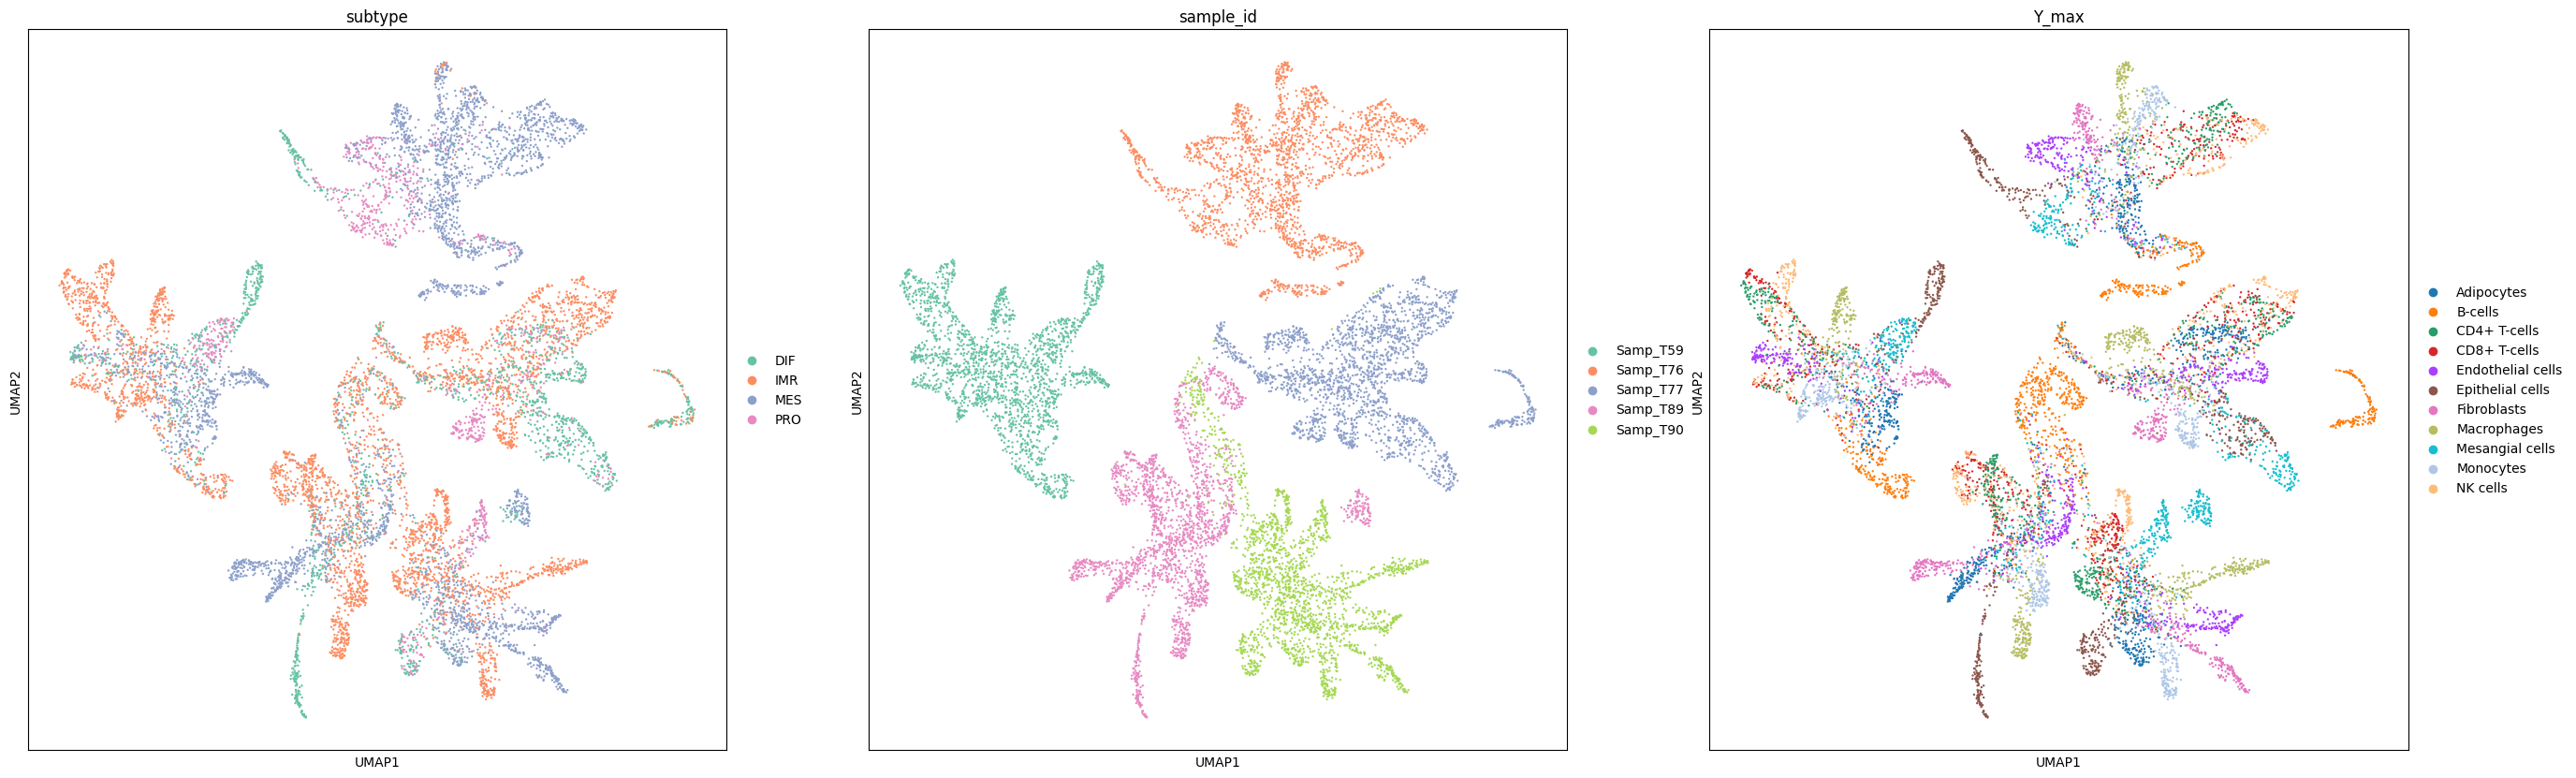

In [11]:
from matplotlib.pyplot import rc_context

# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color=['subtype', 'sample_id', "Y_max"])


In [12]:
tab = adata.obs.groupby(['Y_max', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
Y_max,,,,
Adipocytes,137,56,711,74
B-cells,189,469,297,21
CD4+ T-cells,54,582,261,13
CD8+ T-cells,65,621,245,22
Endothelial cells,243,94,437,166
Epithelial cells,742,26,16,148
Fibroblasts,22,15,766,163
Macrophages,13,807,192,4
Mesangial cells,230,63,207,412


In [13]:
tab = adata.obs.groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_T59,393,933,610,164
Samp_T76,153,27,1503,417
Samp_T77,742,1061,1,296
Samp_T89,365,983,752,0
Samp_T90,148,1032,738,182


In [14]:
set(adata.obs.Y_max)

{'Adipocytes',
 'B-cells',
 'CD4+ T-cells',
 'CD8+ T-cells',
 'Endothelial cells',
 'Epithelial cells',
 'Fibroblasts',
 'Macrophages',
 'Mesangial cells',
 'Monocytes',
 'NK cells'}

In [15]:
tab = adata.obs.groupby(['sample_id', 'subtype']).size() # Epithelial cells
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_T59,393,933,610,164
Samp_T76,153,27,1503,417
Samp_T77,742,1061,1,296
Samp_T89,365,983,752,0
Samp_T90,148,1032,738,182


In [16]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "Epithelial cells")[0]].groupby(['sample_id', 'subtype']).size() # Epithelial cells
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_T59,174,2,1,9
Samp_T76,124,0,2,74
Samp_T77,184,2,0,3
Samp_T89,170,3,0,0
Samp_T90,90,19,13,62


# set the label for Diff Exp

In [17]:
# set the label

cell_type_vec = np.array(["DIF_total"]*adata.obs.sample_id.shape[0])
pro_label_idx = np.where(adata.obs.sample_id.isin(["Samp_T90"]) )[0]
cell_type_vec[pro_label_idx] = "PRO_total"

adata.obs['subtype_total'] = cell_type_vec



In [18]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "Fibroblasts")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_T59,10,0,183,3
Samp_T76,0,0,181,1
Samp_T77,10,14,1,159
Samp_T89,2,1,193,0
Samp_T90,0,0,208,0


In [19]:
immune_ct = ["Endothelial cells"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_T59,57,3,32,8
Samp_T76,0,0,37,63
Samp_T77,88,4,0,8
Samp_T89,13,2,85,0
Samp_T90,0,0,97,3


In [20]:
immune_ct = ["CD4+ T-cells"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_T59,1,96,3,0
Samp_T76,0,0,99,1
Samp_T77,2,98,0,0
Samp_T89,2,90,8,0
Samp_T90,1,86,13,0


In [21]:
immune_ct = ["Macrophages"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_T59,0,100,0,0
Samp_T76,2,14,84,0
Samp_T77,0,100,0,0
Samp_T89,0,100,0,0
Samp_T90,0,100,0,0


# Differential Expression

In [22]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# log data
sc.pp.log1p(adata)

# get high variance genes
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# now process the counts further for doing  
# analysis and the cell clustering
#adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=10)

# calculate PCA
sc.tl.pca(adata, n_comps=20)

# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


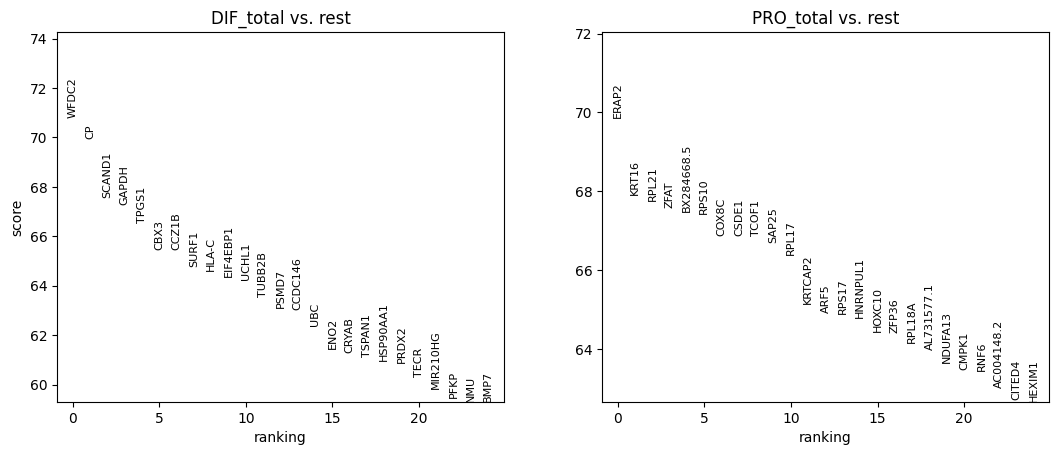

In [23]:
sc.tl.rank_genes_groups(adata, 'subtype_total', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

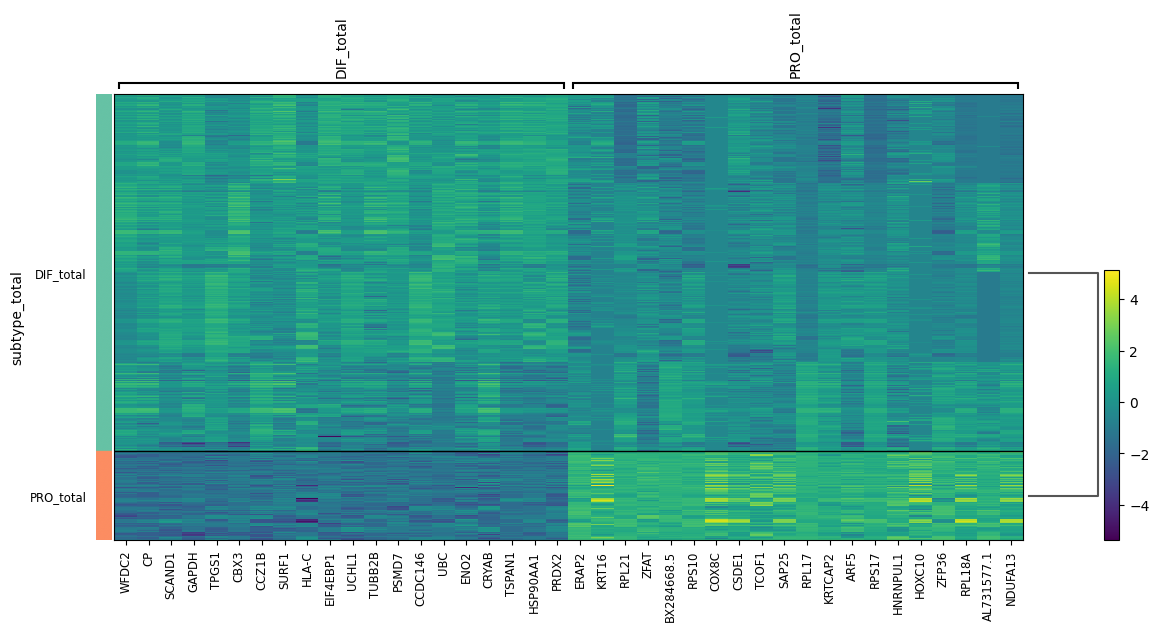

In [24]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=20, key="wilcoxon", groupby="subtype_total", show_gene_labels=True)


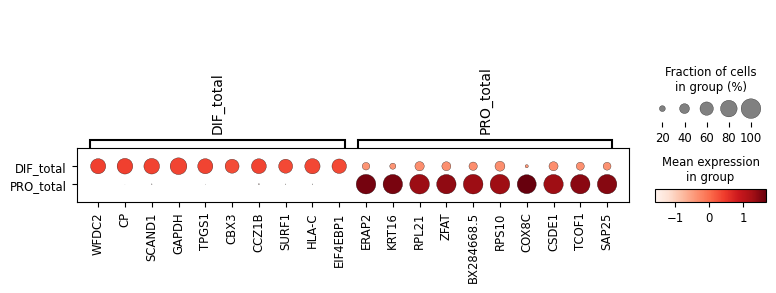

In [25]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key="wilcoxon", groupby="subtype_total")


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


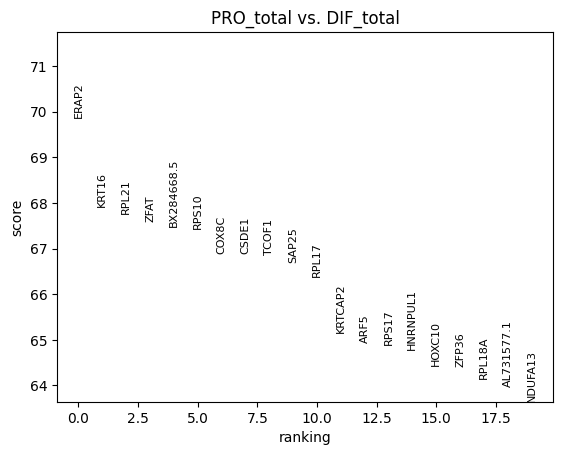

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


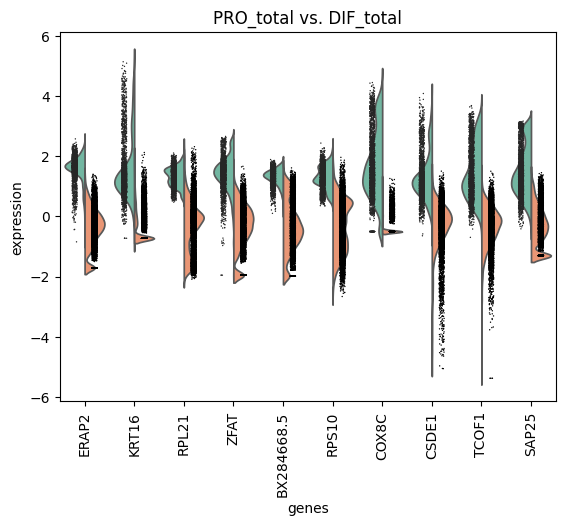

In [26]:
sc.tl.rank_genes_groups(adata, 'subtype_total', groups=['PRO_total'], reference='DIF_total', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['PRO_total'], n_genes=20)
sc.pl.rank_genes_groups_violin(adata, groups='PRO_total', n_genes=10)


In [27]:
wc = adata.uns['wilcoxon']['names']["PRO_total"]
wc[0:100]

array(['ERAP2', 'KRT16', 'RPL21', 'ZFAT', 'BX284668.5', 'RPS10', 'COX8C',
       'CSDE1', 'TCOF1', 'SAP25', 'RPL17', 'KRTCAP2', 'ARF5', 'RPS17',
       'HNRNPUL1', 'HOXC10', 'ZFP36', 'RPL18A', 'AL731577.1', 'NDUFA13',
       'CMPK1', 'RNF6', 'AC004148.2', 'CITED4', 'HEXIM1', 'ALYREF',
       'RPL27', 'PSENEN', 'ALDH1A2', 'RPL23A', 'KLF2', 'PAGE4', 'AOC1',
       'TBC1D3D', 'AC004951.1', 'UBA52', 'AP001160.1', 'RPN1', 'EEF2',
       'RPS25', 'HELZ2', 'LINC01980', 'COMMD6', 'FAM118A', 'IGLV1-36',
       'LINC01970', 'INTS6', 'ARID3A', 'UPK1A', 'EEF1G', 'RPL18', 'MYCN',
       'ZBTB16', 'BTBD1', 'PCBP2', 'FABP5', 'COX6B1', 'MRPS28', 'MED26',
       'ARRDC2', 'PGGHG', 'ALKBH5', 'TMEM259', 'HYOU1', 'LPAR3', 'NOP53',
       'HDAC5', 'IGF2BP1', 'GPR27', 'AL592183.1', 'PROK2', 'HIC1',
       'MMP10', 'EIF2D', 'SUCLG2', 'SSBP4', 'DAZAP1', 'CTDSP1', 'RNPEPL1',
       'DNAJC14', 'TCF20', 'THOC3', 'FAM215B', 'SIK1B', 'VASP', 'TTYH1',
       'CLEC2L', 'RNPEP', 'TCF7', 'LINC00867', 'CCZ1', 'SNX1', '

# Plot results

In [28]:
immune_ct = ["Samp_T76"]
idx = np.where(~adata.obs.sample_id.isin(immune_ct) )[0]
adata = adata[idx]


In [29]:
# get consensusOV genes
consensus_genes = pd.read_csv(consensus_ov_gene_path)
consensus_genes = np.intersect1d(consensus_genes.gene, adata.var.gene_ids)

adata = adata[:, consensus_genes]


consensus_genes

array(['ADAMDEC1', 'ANXA1', 'APOBEC3G', 'BLMH', 'CACNA1C', 'CALD1',
       'CASP1', 'CLU', 'COL4A6', 'COL5A1', 'COL8A1', 'COPS3', 'CXCL10',
       'DDR2', 'DLC1', 'DLEC1', 'EFS', 'EVI2A', 'F2R', 'FCER1G', 'FN1',
       'FSCN1', 'FUT2', 'GAS7', 'GIMAP5', 'IL21R', 'KIF1A', 'KMO', 'LAG3',
       'LAMB1', 'LAPTM5', 'LCN2', 'LGALS1', 'MAPRE1', 'MAPRE2', 'MARCKS',
       'MARCKSL1', 'MFAP2', 'MGLL', 'MLPH', 'MMP14', 'NBL1', 'NETO2',
       'NNMT', 'NUAK1', 'PALLD', 'PCOLCE', 'PDPN', 'PDZK1IP1', 'PKIA',
       'PTGER2', 'RARRES3', 'RHOBTB3', 'RIN1', 'RUNX1', 'SALL2',
       'SCGB2A2', 'SLA', 'SLC31A2', 'SLC37A1', 'SMARCD1', 'SSH3',
       'STEAP3', 'STMN1', 'TCF7L1', 'TNFRSF14', 'TPST1', 'UBE2L6',
       'WIPF1'], dtype=object)

In [30]:
adata

View of AnnData object with n_obs × n_vars = 8400 × 69
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'Macrophages', 'Epithelial cells', 'Monocytes', 'Adipocytes', 'CD8+ T-cells', 'Endothelial cells', 'Mesangial cells', 'CD4+ T-cells', 'Fibroblasts', 'B-cells', 'NK cells', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'subtype_total'
    var: 'gene_ids', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'subtype_colors', 'sample_id_colors', 'Y_max_colors', 'log1p', 'wilcoxon', 'subtype_total_colors', 'dendrogram_subtype_total', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [31]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,Macrophages,Epithelial cells,Monocytes,Adipocytes,CD8+ T-cells,...,Fibroblasts,B-cells,NK cells,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,subtype_total
0,Samp_T59,CTRL,Train,random,sc_ref,0.030000,0.055000,0.205000,0.035000,0.210000,...,0.060000,0.035000,0.025000,0.504,0.220,0.088,0.188,IMR,CD4+ T-cells,DIF_total
1,Samp_T59,CTRL,Train,random,sc_ref,0.275000,0.060000,0.005000,0.055000,0.010000,...,0.030000,0.430000,0.010000,0.442,0.262,0.114,0.182,IMR,B-cells,DIF_total
2,Samp_T59,CTRL,Train,random,sc_ref,0.005000,0.070000,0.560000,0.005000,0.005000,...,0.320000,0.005000,0.005000,0.290,0.206,0.140,0.364,MES,Monocytes,DIF_total
3,Samp_T59,CTRL,Train,random,sc_ref,0.020000,0.005000,0.025000,0.015000,0.515000,...,0.010000,0.100000,0.010000,0.390,0.312,0.168,0.130,IMR,CD8+ T-cells,DIF_total
4,Samp_T59,CTRL,Train,random,sc_ref,0.015000,0.045000,0.115000,0.020000,0.255000,...,0.015000,0.005000,0.365000,0.416,0.374,0.082,0.128,IMR,NK cells,DIF_total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,Samp_T90,CTRL,Train,cell_type_specific,sc_ref,0.026668,0.010228,0.008148,0.003406,0.010293,...,0.008384,0.002011,0.871835,0.922,0.066,0.004,0.008,IMR,NK cells,PRO_total
10496,Samp_T90,CTRL,Train,cell_type_specific,sc_ref,0.003836,0.101083,0.046046,0.099706,0.022706,...,0.006378,0.005489,0.568911,0.376,0.310,0.088,0.226,IMR,NK cells,PRO_total
10497,Samp_T90,CTRL,Train,cell_type_specific,sc_ref,0.014555,0.049026,0.002625,0.005415,0.065198,...,0.002805,0.035035,0.790416,0.636,0.258,0.042,0.064,IMR,NK cells,PRO_total
10498,Samp_T90,CTRL,Train,cell_type_specific,sc_ref,0.043397,0.008603,0.010396,0.006961,0.007803,...,0.030603,0.007744,0.834686,0.632,0.062,0.028,0.278,IMR,NK cells,PRO_total


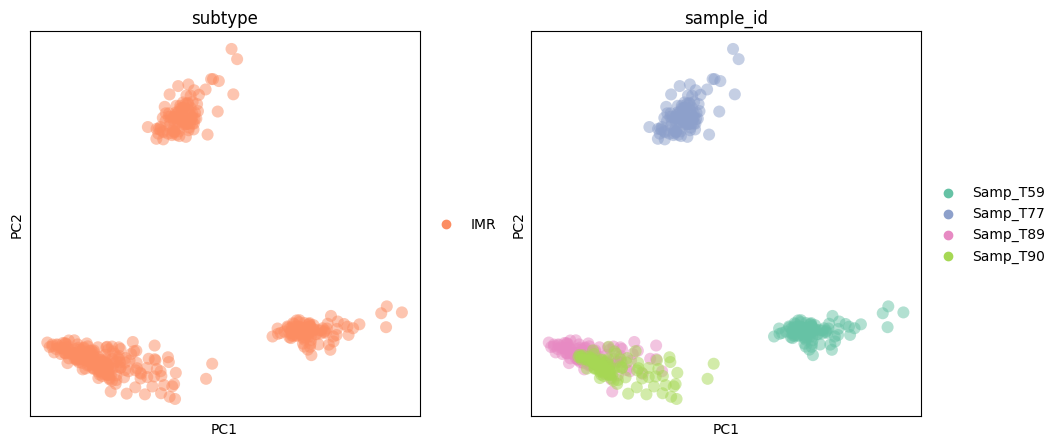

In [32]:
immune_ct = ["Macrophages"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'], alpha=0.5)

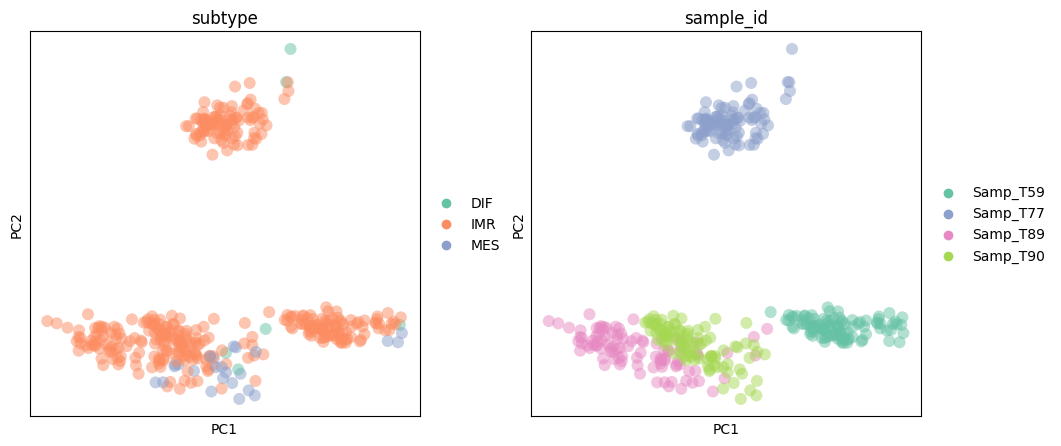

In [33]:
immune_ct = ["CD4+ T-cells"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'], alpha=0.5)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


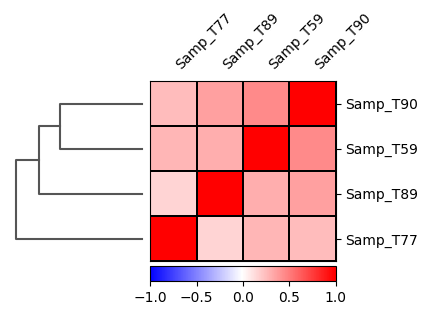

In [34]:
immune_ct = ["Epithelial cells"]
subtype_ct = ["DIF", "PRO"]

idx = np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") 
idx = np.where(np.logical_and(idx, adata.obs.subtype.isin(subtype_ct)) )[0]

sc.pl.correlation_matrix(adata[idx], groupby="sample_id")

In [35]:
adata.obs.columns

Index(['sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type',
       'Macrophages', 'Epithelial cells', 'Monocytes', 'Adipocytes',
       'CD8+ T-cells', 'Endothelial cells', 'Mesangial cells', 'CD4+ T-cells',
       'Fibroblasts', 'B-cells', 'NK cells', 'IMR_consensus', 'DIF_consensus',
       'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'subtype_total'],
      dtype='object')

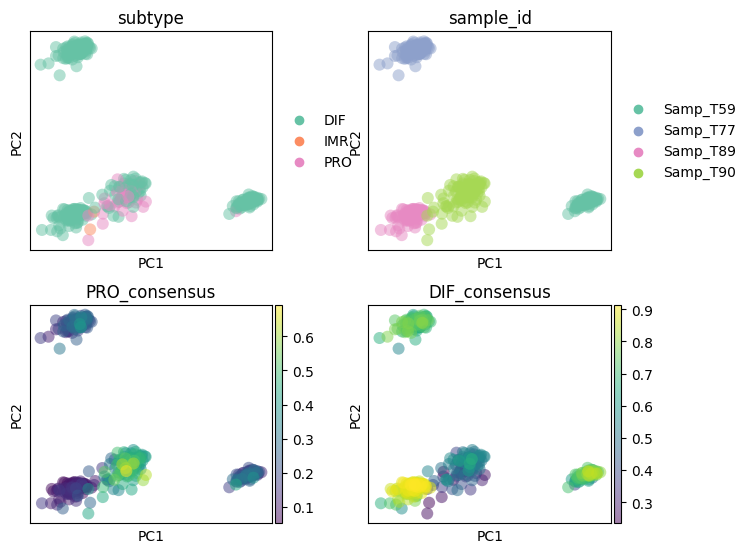

In [36]:
immune_ct = ["Epithelial cells"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id', "PRO_consensus", "DIF_consensus"], ncols=2, alpha=0.5)

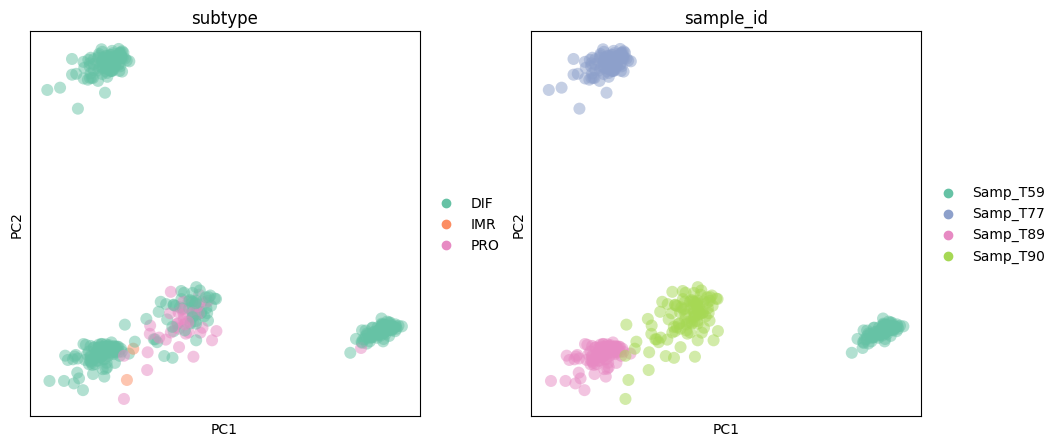

In [37]:
immune_ct = ["Epithelial cells"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]


with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'], alpha=0.5)

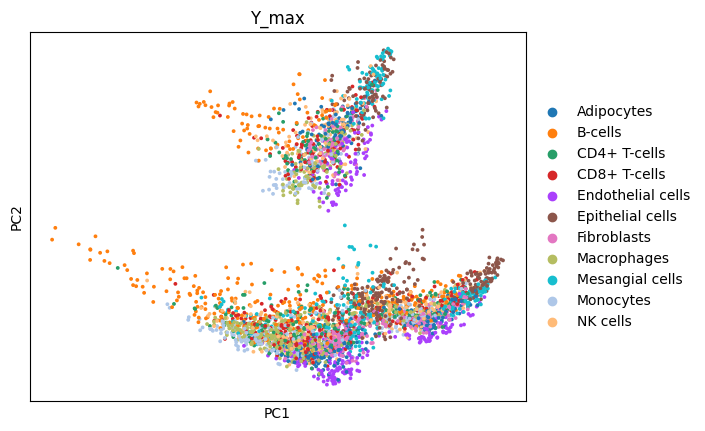

In [38]:
idx = np.where(adata.obs.cell_prop_type == "random" )[0]

sc.pl.pca(adata[idx], color='Y_max')